In [1]:
from mynotebooks import *
%matplotlib inline

arm = Box2DWorld.Arm(position=(0,0), nparts=3, bHand=True)  # Arm creation

### Test of a motor command execution

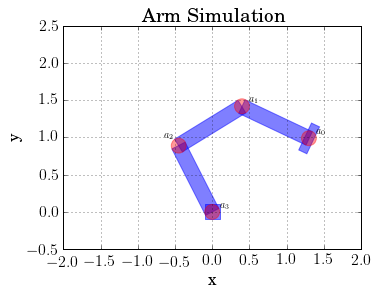

In [2]:
fig, ax = Box2DWorld.makeFigure(axes=[-2,2,-0.5,2.5])
m = [0.5,-1.5,-1,0] # absolute motor joint angles in rad:  limits -2..2, 90 degrees
arm.gotoTargetJoints(m)    
Box2DWorld.plotAll(ax,centers=arm.getSalient(),label="a",xlabel="x",ylabel="y",title="Arm Simulation",mainfont=16)
plt.show()
fig.savefig('imgs/armsim.png', dpi=300, format='png')

## Sensorimotor mapping : f(m)=s

In [3]:
joint_limits = arm.getJointLimits()
m_mins = [j[0] for j in joint_limits] 
m_maxs = [j[1] for j in joint_limits] 
s_mins = [ -3.0,  -2, -np.pi/2.0]
s_maxs = [ 3.0,  3, np.pi/2.0]

env = SensoriMotor.RobotArmEnv(m_mins, m_maxs, s_mins, s_maxs)
fms = SensorimotorModel.from_configuration(env.conf, 'NN')

### f(m)=s learning from scratch

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

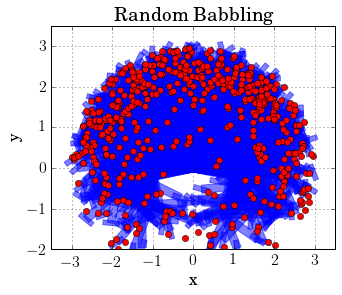

In [4]:
def forward_error(probes = 10):
    fms.mode = "exploit"
    errors_s = []
    for m in env.random_motors(n=probes):
        s = np.array(arm.gotoTargetJoints(m))
        s_pred = fms.forward_prediction(m)
        errors_s.append(VectorFigUtils.dist(s,s_pred))
    fms.mode = "explore"
    return errors_s

fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])
mean_error,mean_var = [],[]
for i in range(500):
    Box2DWorld.printProgress(i)
    m = env.getRandomInput()
    out = env.compute_sensori_effect(m)               
    if(fms.size()>1):
        error = forward_error(20)
        VectorFigUtils.error_monitor(error,mean_error,mean_var)        
        
    fms.update(m, out) 
    Box2DWorld.plotWorld(ax)
    ax.plot(*out[:-1], marker='o', color='red')
    
VectorFigUtils.decorate("x","y","Random Babbling",mainfont=16)
plt.grid()
plt.show()
fig.savefig('imgs/RandomBabbling.png', dpi=300, format='png')

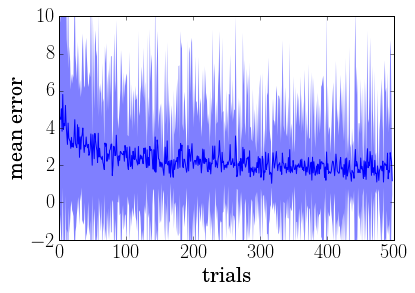

In [32]:
plt.close()
plt.axes(xlim=[0,500],ylim=[-2,10])
VectorFigUtils.drawPlotXY(range(len(mean_error)),mean_error,mean_var,xlabel="trials",ylabel="mean error")
plt.show()
#fig.savefig('imgs/RandomBablingError.png', dpi=300, format='png')

### Error during learning from scratch of f(m)=s (running average)

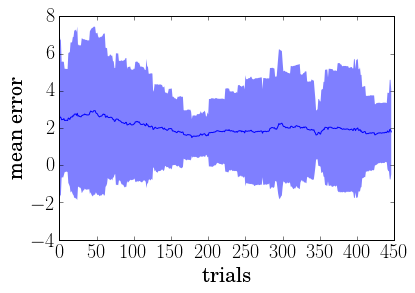

In [6]:
plt.close()
VectorFigUtils.drawPlotXY(range(len(mean_error)),mean_error,mean_var,xlabel="trials",ylabel="mean error")
plt.show()
fig.savefig('imgs/RandomBabblingError.png', dpi=300, format='png')

### Error of forward prediction after learning f(m)=s

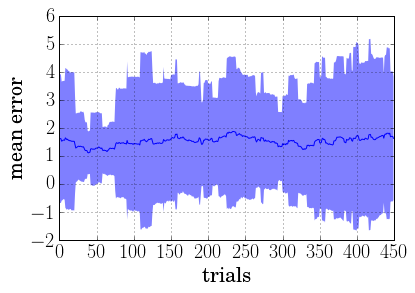

In [8]:
fms.mode = "exploit"
error,mean_error,mean_var = [],[],[]
for i in range(500):
    m = env.getRandomInput()
    out_pred = fms.forward_prediction(m)  
    out = env.compute_sensori_effect(m)               
    VectorFigUtils.error_monitor(out,out_pred,error,mean_error,mean_var)        
    
VectorFigUtils.drawPlotXY(range(len(mean_error)),mean_error,mean_var,xlabel="trials",ylabel="mean error")
fig.savefig('imgs/RandomBabblingError.png', dpi=300, format='png')
plt.grid()

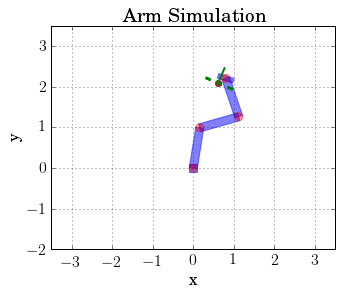

In [30]:
# Test of Forward Prediction
fms.mode = "exploit"
fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])
m = env.getRandomInput()
s_pred = fms.forward_prediction(m)
s = arm.gotoTargetJoints(m)
Box2DWorld.plotWorld(ax)
Box2DWorld.plotVectors(ax, arm.getSalient())
Box2DWorld.plotSensoryState(ax, s_pred[:2], s_pred[2])
VectorFigUtils.decorate("x","y","Arm Simulation",mainfont=16)
plt.show()

### Goal Babbling with progres monitoring sampling an Interest Model

In [3]:
fms_im = InterestModel.from_configuration(env.conf, env.conf.s_dims, 'discretized_progress')

fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])
error,mean_error,mean_var = [],[],[]
for i in range(500):
    s_g = fms_im.sample()                                   # sample a sensory goal using the interest model
    if(fms.size()>2): m = fms.inverse_prediction(s_g)       # infer a motor command to reach that goal using the sensorimotor model
    else: m = env.getRandomInput()
    s = env.compute_sensori_effect(m)                       # execute this command and observe the corresponding sensory effect
    fms.update(m, s)                                        # update the sensorimotor model
    
    if(fms.size()>2): 
        VectorFigUtils.error_monitor(s,s_g,error,mean_error,mean_var)            
        fms_im.update(np.hstack((m, s)), np.hstack((m, s_g)))   # update the interest model
    
    Box2DWorld.plotWorld(ax)
    ax.plot(*s[:-1], marker='o', color='red')

### Error of inverse prediction after learning f(m)=s

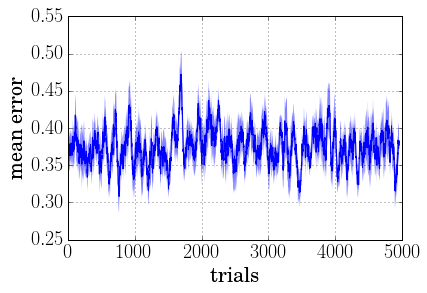

In [6]:
fms.mode = "exploit"
error,mean_error,mean_var = [],[],[]
for i in range(5000):
    s_g = fms_im.sample()                                   
    m = fms.inverse_prediction(s_g)    
    s = env.compute_sensori_effect(m)               
    VectorFigUtils.error_monitor(s,s_g,error,mean_error,mean_var)        
    
plt.close()
VectorFigUtils.drawPlotXY(range(len(mean_error)),mean_error,mean_var,xlabel="trials",ylabel="mean error")
fig.savefig('imgs/ProgressBabblingError.png', dpi=300, format='png')
plt.grid()
plt.show()
